In [1]:
import gym
import numpy as np

In [2]:


env = gym.make('CartPole-v0')
for i_episode in range(1):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        print(action)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[2018-01-08 22:00:11,230] Making new env: CartPole-v0


[-0.01926209  0.03578199  0.00489915  0.02140128]
0
[-0.01854645 -0.15940987  0.00532717  0.31562591]
1
[-0.02173464  0.03563579  0.01163969  0.02462774]
1
[-0.02102193  0.2305889   0.01213225 -0.26436012]
0
[-0.01641015  0.0352959   0.00684504  0.03212461]
1
[-0.01570423  0.23031903  0.00748754 -0.2583908 ]
1
[-0.01109785  0.42533329  0.00231972 -0.54870267]
1
[-0.00259119  0.62042258 -0.00865433 -0.84065382]
1
[ 0.00981727  0.8156616  -0.02546741 -1.13604573]
1
[ 0.0261305   1.0111073  -0.04818832 -1.43660582]
1
[ 0.04635264  1.20678906 -0.07692044 -1.74394961]
1
[ 0.07048843  1.40269716 -0.11179943 -2.05953515]
0
[ 0.09854237  1.20888008 -0.15299014 -1.80342515]
0
[ 0.12271997  1.01576277 -0.18905864 -1.5619365 ]
1
Episode finished after 14 timesteps


In [3]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Discrete(2)
Box(4,)
[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


In [4]:
x = np.array([-2.4, 0, -4.0, 4, 2])
bins = np.linspace(-4.8, 4.8, 12)
out = np.digitize(x, bins)
print(bins)
print(out)

a = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 8) for i in range(4)]

print(len(a))
print(a)

[-4.8        -3.92727273 -3.05454545 -2.18181818 -1.30909091 -0.43636364
  0.43636364  1.30909091  2.18181818  3.05454545  3.92727273  4.8       ]
[ 3  6  1 11  8]
4
[array([-4.8       , -3.42857143, -2.05714286, -0.68571429,  0.68571429,
        2.05714286,  3.42857143,  4.8       ]), array([ -3.40282347e+38,  -2.43058819e+38,  -1.45835291e+38,
        -4.86117638e+37,   4.86117638e+37,   1.45835291e+38,
         2.43058819e+38,   3.40282347e+38]), array([-0.41887902, -0.2991993 , -0.17951958, -0.05983986,  0.05983986,
        0.17951958,  0.2991993 ,  0.41887902]), array([ -3.40282347e+38,  -2.43058819e+38,  -1.45835291e+38,
        -4.86117638e+37,   4.86117638e+37,   1.45835291e+38,
         2.43058819e+38,   3.40282347e+38])]


In [346]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import unittest
import math


# env = gym.make('CartPole-v0')
# env.reset()


# Qlearner for CartPole
class QLearner():
    def __init__(self, env):
        self.env = env
        self.epsilon_start = 0.1 # 1-epsilon probability of selecting best action
        self.epsilon_end = 0.99 # final epsilon value
        self.epsilon_decay = 5000 # steps before epsilon reaches epsilon_end
        self.epsilon_step = 0 #step tracker
        self.alpha = 0.01
        self.gamma = 0.99
        
        # get initial state, divide continuous states into discrete bins
#         self.bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 7) for i in range(4)]
        self.bins = []
        self.bins.append(np.linspace(-2.4, 2.4, 1))
        self.bins.append(np.linspace(-0.5, 0.5, 1))
        self.bins.append(np.linspace(-41.8, 41.8, 5))
        self.bins.append(np.linspace(-math.radians(50), math.radians(50), 3))
        self.reset()
        
        #initialize Q
        self.Q = np.zeros((2, 2, 6, 4, 2))
#         print(self.bins)

        self.episode_durations = []
        
    
    def getQ(self, s, action):
        return self.Q[s[0], s[1], s[2], s[3], action]
    
    
    def setQ(self, s, s_plus1, action, r):
#         print("Setting Q: ")
#         print("s: ", s, "s_plus1: ", s_plus1, " action: ", action, " r: ", r)
#         print("s:", s[0], s[1], s[2], s[3], "action: ", action)
        q = self.getQ(s, action)
        max_q_splus1 = np.max(self.Q[s_plus1[0], s_plus1[1], s_plus1[2], s_plus1[3]])
#         print("q: ", q, " max_q_splus1: ", max_q_splus1)
        new_q = q + self.alpha * (r + self.gamma * max_q_splus1 - q)

#         print("new q: ", new_q, " position: ", s[0], s[1], s[2], s[3], action)
        self.Q[s[0], s[1], s[2], s[3], action] = new_q
    
    def get_best_action(self, s):
        return np.argmax(self.Q[s[0], s[1], s[2], s[3]])
    
    def get_epsilon(self):
        return min(self.epsilon_end, self.epsilon_start + 
                      self.epsilon_step / self.epsilon_decay * (self.epsilon_end - self.epsilon_start))
    
    def get_training_action(self):
        epsilon = self.get_epsilon()

        if np.random.rand() >= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.get_best_action(self.s_bins)
        
        self.epsilon_step += 1
        return action
    
    def reset(self):
        self.s = env.reset()
        self.s_bins = [np.digitize(self.s[i], self.bins[i]) for i in range(4)]
        self.s_bins[0] = 0
        self.s_bins[1] = 0
    
    def step(self, action, training=False):
        s_plus1, r, done, _ = self.env.step(action)
#         print("s0:", self.s)
#         print("s1:", s_plus1)
#         print("velocity:", s_plus1[3])
        s_bins = [np.digitize(s_plus1[i], self.bins[i]) for i in range(4)]
        s_bins[0] = 0
        s_bins[1] = 0
#         if training:
        self.setQ(self.s_bins, s_bins, action, r)
            
        self.s_bins = s_bins
        
        return r, done
    
    def train(self, nb_episodes=2):
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_training_action()
                r, done = self.step(action, training=True)
                episode_reward += r
                
                if done:
                    break;
            self.episode_durations.append(episode_reward + 1)
#             self.plot_durations()            
#             print("Episode reward: ", episode_reward)

    def run(self):
        self.reset()
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_best_action(self.s_bins)
            r, done = self.step(action)
            episode_reward += r
#             time.sleep(0.1)
            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
            
#     def plot_durations(self):
#         plt.figure(2)
#         plt.clf()
# #         durations_t = torch.FloatTensor(episode_durations)
#         plt.title('Training...')
#         plt.xlabel('Episode')
#         plt.ylabel('Duration')
#         plt.plot(self.episode_durations)
#         # Take 100 episode averages and plot them too
# #         if len(durations_t) >= 100:
# #             means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
# #             means = torch.cat((torch.zeros(99), means))
# #             plt.plot(means.numpy())

#         plt.pause(0.001)  # pause a bit so that plots are updated
#         if is_ipython:
#             display.clear_output(wait=True)
#             display.display(plt.gcf())


class TestQlearner(unittest.TestCase):
    def setUp(self):
        env = gym.make('CartPole-v0')
        self.qlearner = QLearner(env)

    def test_setQ(self):
        self.qlearner.setQ([4, 4, 4, 4], [4, 4, 4, 5], 1, 1)
        self.assertEqual(self.qlearner.getQ([4, 4, 4, 4], 1), 0.01)
        
        print(' ')
        self.qlearner.setQ([4, 4, 4, 5], [4, 4, 4, 4], 0, 1)
        newQ = self.qlearner.getQ([4, 4, 4, 5], 0)
        self.assertEqual(newQ, 0.010099)
        
        
    def runTest(self):
        self.test_setQ()
        



# tester = TestQlearner()
# tester.debug()


[2018-01-08 23:15:21,460] Making new env: CartPole-v0


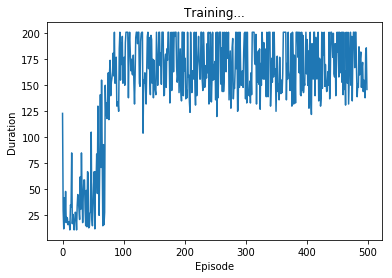

In [353]:
env = gym.make('CartPole-v0')
qlearner = QLearner(env)

qlearner.train(nb_episodes=500)
plt.figure(2)
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(qlearner.episode_durations)



In [309]:
# env.close()
qlearner.run()
# env.close()

Total Reward:  150.0


In [283]:
qlearner.Q[0, 0, 3, 2]

array([ 42.86020243,  76.54825018])

In [232]:
# qlearner.Q[3:6, 3:6, 3:6, 3:6]
print(qlearner.get_epsilon(), qlearner.epsilon_step)

0.99 10737


In [ ]:
start = 0.1
end = 0.95
decay = 10
step = 11

epsilon = min(end, start + step / decay * (end - start))
print(epsilon)

In [224]:
np.linspace(-100, 100, 2)

array([-100.,  100.])

# The above doesn't seem right, have to reduce dimension significantly
## which means it requiers n-step bootstrapping rather than 1 step or we'll have to use a rollout 

In [469]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import unittest
import math


# env = gym.make('CartPole-v0')
# env.reset()


# Qlearner for CartPole
class QLearner():
    def __init__(self, env):
        self.env = env
        self.epsilon_start = 0.1 # 1-epsilon probability of selecting best action
        self.epsilon_end = 0.95 # final epsilon value
        self.epsilon_decay = 5000 # steps before epsilon reaches epsilon_end
        self.epsilon_step = 0 #step tracker
        self.alpha = 0.05
        self.gamma = 0.9
        
        # get initial state, divide continuous states into discrete bins
#         self.bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], 7) for i in range(4)]
        self.bins = []
        self.bins.append(np.linspace(-0.5, 0.5, 3))
        self.bins.append(np.linspace(-1.0, 1.0, 3))
        self.bins.append(np.linspace(-1., 1., 7))
        self.bins.append(np.linspace(-.5, .5, 4))
        self.reset()
        
        #initialize Q
        self.Q = np.zeros((4, 4, 8, 5, 2))
#         print(self.bins)

        self.episode_durations = []
        
    
    def getQ(self, s, action):
        return self.Q[s[0], s[1], s[2], s[3], action]
    
    
    def setQ(self, s, s_plus1, action, r):
#         print("Setting Q: ")
#         print("s: ", s, "s_plus1: ", s_plus1, " action: ", action, " r: ", r)
#         print("s:", s[0], s[1], s[2], s[3], "action: ", action)
        q = self.getQ(s, action)
        max_q_splus1 = np.max(self.Q[s_plus1[0], s_plus1[1], s_plus1[2], s_plus1[3]])
#         print("q: ", q, " max_q_splus1: ", max_q_splus1)
        new_q = q + self.alpha * (r + self.gamma * max_q_splus1 - q)

#         print("new q: ", new_q, " position: ", s[0], s[1], s[2], s[3], action)
        self.Q[s[0], s[1], s[2], s[3], action] = new_q
    
    def get_best_action(self, s):
        return np.argmax(self.Q[s[0], s[1], s[2], s[3]])
    
    def get_epsilon(self):
        return min(self.epsilon_end, self.epsilon_start + 
                      self.epsilon_step / self.epsilon_decay * (self.epsilon_end - self.epsilon_start))
    
    def get_training_action(self):
        epsilon = self.get_epsilon()

        if np.random.rand() >= epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.get_best_action(self.s_bins)
        
        self.epsilon_step += 1
        return action
    
    def reset(self):
        self.s = env.reset()
        self.s_bins = [np.digitize(self.s[i], self.bins[i]) for i in range(4)]
    
    def step(self, action, training=False):
        s_plus1, r, done, _ = self.env.step(action)
#         print("s0:", self.s)
#         print("s1:", s_plus1)
#         print("velocity:", s_plus1[3])
        s_bins = [np.digitize(s_plus1[i], self.bins[i]) for i in range(4)]
#         if training:
        self.setQ(self.s_bins, s_bins, action, r)
            
        self.s_bins = s_bins
        
        return r, done
    
    def train(self, nb_episodes=2):
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_training_action()
                r, done = self.step(action, training=True)
                
                if episode_reward < 150 and done:
                    r = -200
                
                episode_reward += r
                
                if done:
                    break;
            self.episode_durations.append(episode_reward + 1)
#             self.plot_durations()            
            print("Episode reward: ", episode_reward)

    def run(self):
        self.reset()
        self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_best_action(self.s_bins)
            r, done = self.step(action)
            episode_reward += r
#             time.sleep(0.1)
            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
        
class TestQlearner(unittest.TestCase):
    def setUp(self):
        env = gym.make('CartPole-v0')
        self.qlearner = QLearner(env)

    def test_setQ(self):
        self.qlearner.setQ([4, 4, 4, 4], [4, 4, 4, 5], 1, 1)
        self.assertEqual(self.qlearner.getQ([4, 4, 4, 4], 1), 0.01)
        
        print(' ')
        self.qlearner.setQ([4, 4, 4, 5], [4, 4, 4, 4], 0, 1)
        newQ = self.qlearner.getQ([4, 4, 4, 5], 0)
        self.assertEqual(newQ, 0.010099)
        
        
    def runTest(self):
        self.test_setQ()
        



# tester = TestQlearner()
# tester.debug()


[2018-01-09 00:33:02,235] Making new env: CartPole-v0


Episode reward:  -155.0
Episode reward:  -174.0
Episode reward:  -180.0
Episode reward:  -170.0
Episode reward:  -179.0
Episode reward:  -170.0
Episode reward:  -189.0
Episode reward:  -181.0
Episode reward:  -178.0
Episode reward:  -186.0
Episode reward:  -191.0
Episode reward:  -161.0
Episode reward:  -169.0
Episode reward:  -180.0
Episode reward:  -188.0
Episode reward:  -156.0
Episode reward:  -183.0
Episode reward:  -184.0
Episode reward:  -165.0
Episode reward:  -182.0
Episode reward:  -184.0
Episode reward:  -175.0
Episode reward:  -175.0
Episode reward:  -185.0
Episode reward:  -172.0
Episode reward:  -141.0
Episode reward:  -188.0
Episode reward:  -179.0
Episode reward:  -151.0
Episode reward:  -179.0
Episode reward:  -179.0
Episode reward:  -184.0
Episode reward:  -179.0
Episode reward:  -179.0
Episode reward:  -182.0
Episode reward:  -173.0
Episode reward:  -188.0
Episode reward:  -179.0
Episode reward:  -182.0
Episode reward:  -187.0
Episode reward:  -186.0
Episode reward: 

Episode reward:  -191.0
Episode reward:  -184.0
Episode reward:  -162.0
Episode reward:  -192.0
Episode reward:  -185.0
Episode reward:  -184.0
Episode reward:  -189.0
Episode reward:  -168.0
Episode reward:  -159.0
Episode reward:  -170.0
Episode reward:  -178.0
Episode reward:  -174.0
Episode reward:  -191.0
Episode reward:  -192.0
Episode reward:  -192.0
Episode reward:  -182.0
Episode reward:  -183.0
Episode reward:  -188.0
Episode reward:  -180.0
Episode reward:  -179.0
Episode reward:  -177.0
Episode reward:  -164.0
Episode reward:  -181.0
Episode reward:  -191.0
Episode reward:  -177.0
Episode reward:  -188.0
Episode reward:  -183.0
Episode reward:  -192.0
Episode reward:  -179.0
Episode reward:  -189.0
Episode reward:  -162.0
Episode reward:  -166.0
Episode reward:  -193.0
Episode reward:  -191.0
Episode reward:  -182.0
Episode reward:  -183.0
Episode reward:  -174.0
Episode reward:  -191.0
Episode reward:  -192.0
Episode reward:  -185.0
Episode reward:  -192.0
Episode reward: 

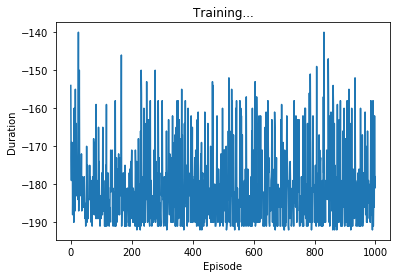

In [472]:
env = gym.make('CartPole-v0')
qlearner = QLearner(env)

qlearner.train(nb_episodes=1000)
plt.figure(2)
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(qlearner.episode_durations)

In [456]:
qlearner.run()  # this result also sucks

Total Reward:  13.0
